

# Bayes Rule and Bayes Classification

This assignment is broken up into two main sections
1. Naive Bayes Classification Walkthrough
2. Exercises

In the first section, please read through the text and run the code to follow through how we can use Python/Pandas to build Bayes models. In the second section, you are asked to complete two exercises using Bayes to build machine learning models.



## Naive Bayes Classification Walkthrough

*Classification* is one form of supervised learning. The aim is to annotate all data points with a label. Those points that have the same label belong to the same class. There can be two or more labels. For example, a lifeform can be classified (coarsely) with labels animal, plant, fungi, archaea, bacteria, protozoa, and chromista. The data points are observed to have certain features that can be used to predict their labels. For example, if it is has feathers, then it is most likely an animal.

In supervised learning an algorithm is first given a training set of data points with their features and labels. Then the algorithm learns from these features and labels a (probabilistic) model, which can afterwards be used to predict the labels of previously unseen data.

*Naive Bayes classification* is a fast and simple to understand classification method. Its speed is due to some simplifications we make about the underlying probability distributions, namely, the assumption about the independence of features. Yet, it can be quite powerful, especially when there are enough features in the data.

Suppose we have for each label L a probability distribution. This distribution gives probability for each possible combination of features (a feature vector):

$$P(features | L).$$

The main idea in Bayesian classification is to reverse the direction of dependence: we want to predict the label based on the features:

$$P(L | features)$$

This is possible by [the Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(L | features) = \frac{P(features | L)P(L)}{P(features)}.$$

Let's assume we have to labels L1 and L2, and their associated distributions: $P(features | L1)$ and $P(features | L2)$. If we have a data point with "features", whose label we don't know, we can try to predict it using the ratio of posterior probabilities:

$$\frac{P(L1 | features)}{P(L2 | features)} = \frac{P(features | L1)P(L1)}{P(features | L2)P(L2)}.$$

If the ratio is greater than one, we label our data point with label L1, and if not, we give it label L2.
The prior probabilities P(L1) and P(L2) of labels can be easily found out from the input data, as for each data point we also have its label. Same goes for the probabilities of features conditioned on the label.

We first demonstrate naive Bayes classification using Gaussian distributions.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

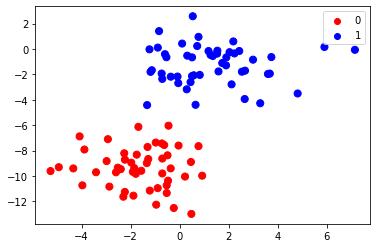

In [6]:
from sklearn.datasets import make_blobs
X,y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
colors=np.array(["red", "blue"])
plt.scatter(X[:, 0], X[:, 1], c=colors[y], s=50)
for label, c in enumerate(colors):
    plt.scatter([], [], c=c, label=str(label))
plt.legend();
#plt.colorbar();

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
model = GaussianNB()
#model = MultinomialNB()
model.fit(X, y);

Naive Bayes algorithm fitted two 2-dimensional Gaussian distribution to the data. The means and the variances define these distributions completely.

In [11]:
print("Means:", model.theta_)
print("Standard deviations:", model.sigma_)

Means: [[-1.64939095 -9.36891451]
 [ 1.29327924 -1.24101221]]
Standard deviations: [[2.06097005 2.47716872]
 [3.33164807 2.22401384]]


Let's plot these distributions. First we define a helper function to draw an ellipse that gives the standard deviation in each direction from the origo.

In [14]:
def plot_ellipse(ax, mu, sigma, color="k", label=None):
    """
    Based on
    http://stackoverflow.com/questions/17952171/not-sure-how-to-fit-data-with-a-gaussian-python.
    """
    from matplotlib.patches import Ellipse
    # Compute eigenvalues and associated eigenvectors
    vals, vecs = np.linalg.eigh(sigma)

    # Compute "tilt" of ellipse using first eigenvector
    x, y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))

    # Eigenvalues give length of ellipse along each eigenvector
    w, h = 2 * np.sqrt(vals)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ellipse = Ellipse(mu, w, h, theta, color=color, label=label)  # color="k")
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_alpha(0.2)
    ax.add_artist(ellipse)
    return ellipse

Then we do the actual plotting:

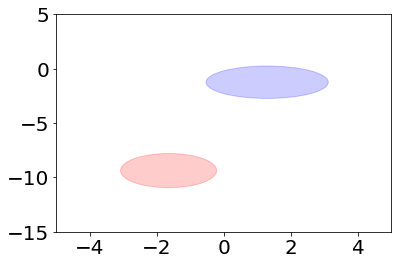

In [16]:
plt.figure()
plt.xlim(-5, 5)
plt.ylim(-15, 5)
plot_ellipse(plt.gca(), model.theta_[0], np.identity(2)*model.sigma_[0], color="red")
plot_ellipse(plt.gca(), model.theta_[1], np.identity(2)*model.sigma_[1], color="blue");

*Accuracy score* gives a measure about how well we managed to predict the labels. The maximum value is 1.0.

In [18]:
from sklearn.metrics import accuracy_score
y_fitted = model.predict(X)
acc=accuracy_score(y,y_fitted)
print("Accuracy score is", acc)

Accuracy score is 1.0


The score was the best possible, which is not a surprise, since we tried to predict the data we had already seen! Later we will split our data into two parts: one for learning the model and the other for testing its predictive skills.

## [Question - Accuracy]
What is a situation when the accuracy score is not a good representation of the quality of a classification?

## [Answer - Accuracy]

Accuracy is a statistic that sums up how well a model performs across all classes. It's helpful when all of the classes are equally important. The ratio between the number of right guesses and the total number of forecasts is used to compute it.

Accuracy = (TP + TN)/(TP + TN + FP + FN)

When both classes are equally important, accuracy is usually a suitable evaluation metric. The accuracy evaluation metric, on the other hand, has certain flaws as well. Some of the major issues with accuracy:

- Unbalanced dataset - When dealing with unbalanced data, we may reach a 95 percent or higher accuracy rate, however this is not a good result if 95 records out of 100 belong to the same class, since we may do this by constantly forecasting the most common class value. Fraud detection data, cancer datasets, and other imbalance datasets are examples.

- Classification problems related to *Multi-Class* - With three or more classes, we may achieve an accuracy of 80%, but we don't know if this is because all classes are predicted equally well or if the model is overlooking one or two classes.


### Another example

Let's generate some more data using multivariate normal distributions.

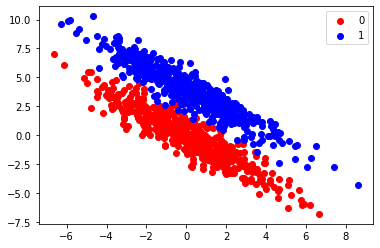

In [20]:
cov=np.array([[ 4.68, -4.32],
 [-4.32,  4.68]])
mean1 = [0,0]
mean2 = [0,4]
n=500
x1 = np.random.multivariate_normal(mean1, cov, n).T
x2 = np.random.multivariate_normal(mean2, cov, n).T
X=np.vstack([x1.T,x2.T])
y=np.hstack([[0]*n, [1]*n]).T
plt.scatter(X[:n,0], X[:n,1], color="red", label=0)
plt.scatter(X[n:,0], X[n:,1], color="blue", label=1)
plt.legend();

The two clusters seem to be quite separate. Let's try naive Bayesian classification on this data.

In [23]:
model = GaussianNB()
#model = MultinomialNB()
model.fit(X, y);

In [25]:
print("Means:", model.theta_)
print("Standard deviations:", model.sigma_)

Means: [[ 0.0955019  -0.1263242 ]
 [ 0.05871333  3.91782508]]
Standard deviations: [[4.87062017 4.94210129]
 [4.97391425 4.91791011]]


Accuracy score is 0.816


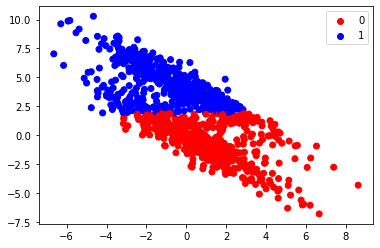

In [27]:
y_fitted = model.predict(X)
colors=np.array(["red", "blue"])
plt.scatter(X[:,0], X[:,1], color=colors[y_fitted])
plt.scatter([], [], color="red", label="0")
plt.scatter([], [], color="blue", label="1")
from sklearn.metrics import accuracy_score
acc=accuracy_score(y,y_fitted)
plt.legend()
print("Accuracy score is", acc)

Even thought the score is quite good, we can see from the plot that the algorithm didn't have good models for the data. We can plot the models the algorithm used:

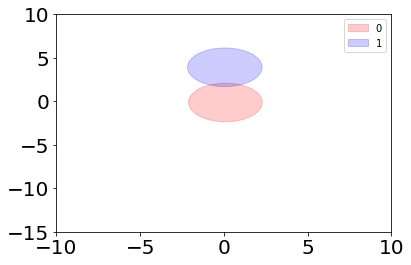

In [29]:
plt.figure()
plt.xlim(-10, 10)
plt.ylim(-15, 10)
e1=plot_ellipse(plt.gca(), model.theta_[0], np.identity(2)*model.sigma_[0], color="red", label="0")
e2=plot_ellipse(plt.gca(), model.theta_[1], np.identity(2)*model.sigma_[1], color="blue", label="1")
plt.legend([e1, e2], ["0", "1"]);

The problem with naive Bayesian classification is that it tries to model the data using Gaussian distributions, which are aligned along the x and y axes. With this example data we would have needed Gaussian distributions which are "tilted".

### Text classification

We next try to classify a set of messages that were posted on a public forum. The messages were divided into groups by the topics. So, we have a data set ready for classification testing. Let's first load this data using scikit-learn and print the message categories.

In [30]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We concentrate on four message categories only. The tool `fetch_20newsgroups` allows us to easily split the data into training and testing data.

In [32]:
categories = ['comp.graphics', 'rec.autos', 'sci.electronics', 'sci.crypt']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Let's see what we got:

In [33]:
print("Training data:", "Data:", str(type(train.data)), len(train.data), "Target:", str(type(train.target)), len(train.target))
print("Test data:", "Data:", str(type(test.data)), len(test.data), "Target", str(type(test.data)), len(test.target))

Training data: Data: <class 'list'> 2364 Target: <class 'numpy.ndarray'> 2364
Test data: Data: <class 'list'> 1574 Target <class 'list'> 1574


We use as features the frequencies of each word in the dataset. That is, there are as many features as there are distinct words in the dataset. We denote the number of features by $f$. As the features are now counts, it is sensible to use multinomial distribution instead of Gaussian. 

Let's try to model these messages using multinomial distributions. Each message category has its own distribution. A multinomial distribution has $f$ non-negative parameters $\theta_1,\ldots , \theta_f$, which sum up to one. For example, the parameter $\theta_3$ might tell the the probability of the word "board" appearing in a message of the category this distribution is describing.

In scikit-learn there is a class `CountVectorizer` that converts messages in form of text strings to feature vectors. We can integrate this conversion with the model we are using (multinomial naive Bayes), so that the conversion happens automatically as part of the `fit` method. We achive this integration using the `make_pipeline` tool.

In [34]:
#from sklearn.feature_extraction.text import TfidfVectorizer  # an alternative feature extractor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

#model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(train.data, train.target)
labels_fitted = model.predict(test.data)
print("Accuracy score is", accuracy_score(labels_fitted, test.target))

Accuracy score is 0.920584498094028


The classifier seem to work quite well! Notice that now we used separate data for testing the model.

Let's have a closer look at the resulting feature vectors.

In [35]:
vec=CountVectorizer()
features=vec.fit_transform(train.data)
print("Type of feature matrix:", type(features))
print(features[0,:])        # print the features of the first sample point

Type of feature matrix: <class 'scipy.sparse.csr.csr_matrix'>
  (0, 15373)	1
  (0, 18962)	3
  (0, 21852)	5
  (0, 9553)	4
  (0, 34790)	6
  (0, 13317)	6
  (0, 19099)	1
  (0, 16034)	1
  (0, 30377)	1
  (0, 26624)	1
  (0, 23858)	1
  (0, 20509)	1
  (0, 15109)	2
  (0, 11079)	1
  (0, 23854)	2
  (0, 32729)	1
  (0, 20381)	1
  (0, 2100)	1
  (0, 12580)	1
  (0, 18085)	1
  (0, 27158)	1
  (0, 31686)	6
  (0, 23118)	1
  (0, 25400)	1
  (0, 17310)	1
  :	:
  (0, 11100)	1
  (0, 27521)	1
  (0, 29104)	1
  (0, 5980)	1
  (0, 30641)	1
  (0, 27517)	1
  (0, 12577)	1
  (0, 25336)	1
  (0, 24025)	1
  (0, 18436)	1
  (0, 29505)	1
  (0, 29494)	1
  (0, 11068)	1
  (0, 21787)	1
  (0, 23460)	1
  (0, 34425)	1
  (0, 16809)	1
  (0, 17883)	1
  (0, 31398)	1
  (0, 34222)	1
  (0, 25926)	1
  (0, 6320)	1
  (0, 29697)	1
  (0, 19220)	1
  (0, 20579)	1


The feature matrix is stored in sparse format, that is, only the nonzero counts are stored. How many words were in the first message?

In [36]:
print("Number of words:", features[0,:].sum())
col = vec.vocabulary_["it"]   # Get the column of 'it' word in the feature matrix
print(f"Word 'it' appears in the first message {features[0, col]} times.")
print()
print(train.data[0])   # Let's print the corresponding message as well
#print(vec.get_feature_names())

Number of words: 177
Word 'it' appears in the first message 2 times.

From: jgfoot@minerva.cis.yale.edu (Josh A. Goldfoot)
Subject: Re: Organized Lobbying for Cryptography
Organization: Yale University
Lines: 21
Distribution: inet
Reply-To: jgfoot@minerva.cis.yale.edu
NNTP-Posting-Host: minerva.cis.yale.edu
X-Newsreader: TIN [version 1.1 Minerva PL9]

Shaun P. Hughes (sphughes@sfsuvax1.sfsu.edu) wrote:
: In article <1r3jgbINN35i@eli.CS.YALE.EDU> jgfoot@minerva.cis.yale.edu writes:
[deletion]
: >Perhaps these encryption-only types would defend the digitized porn if it
: >was posted encrypted?
: >
: >These issues are not as seperable as you maintain.
: >

: Now why would anyone "post" anything encrypted? Encryption is only of 
: use between persons who know how to decrypt the data.

: And why should I care what other people look at? 

I was responding to another person (Tarl Neustaedter) who held that the
EFF wasn't the best organization to fight for crytography rights since the
EFF also

## Exercises

#### <div class="alert alert-info">Exercise 1 (blob classification)</div>

Write function `blob_classification` that gets feature matrix X and label vector y as parameters. It should then return the accuracy score of the prediction. Do the prediction using `GaussianNB`, and use `train_test_split` function from `sklearn` to split the dataset in to two parts: one for training and one for testing. Give parameter `random_state=0` to the splitting function so that the result is deterministic. Use training set size of 75% of the whole data.
<hr/>

In [38]:
# Import packages from sklearn library
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

In [42]:
# Method for classification using the Gaussian Naive Bayes Theorem

def blob_classification(x, y):
    
    # Splitting the x and y data sets into testing and training data sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    
    # Fitting the Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(x_train, y_train)
    
    # Predicting classes of the blobs
    y_fit = model.predict(x_test)
    
    # Calculate and return the accuracy
    accuracy = accuracy_score(y_test, y_fit)
    return(accuracy)

In [44]:
# Creating/Generating the blobs

x,y = make_blobs(1000, 2, centers=2, random_state=0, cluster_std=1.5)

# Calling the 'blob_classification' method
# - Passing the parameters x and y
# - Method returns the accuracy of Naive Bayes Theorem
blob_classification(x, y)

0.872

#### <div class="alert alert-info">Exercise 2 (plant classification)</div>

Write function `plant_classification` that does the following:

* loads the iris dataset using sklearn (`sklearn.datasets.load_iris`)
* splits the data into training and testing part using the `train_test_split` function so that the training set size is 80% of the whole data (give the call also the `random_state=0` argument to make the result deterministic)
* use Gaussian naive Bayes to fit the training data
* predict labels of the test data
* the function should return the accuracy score of the prediction performance (`sklearn.metrics.accuracy_score`)
<hr/>

In [46]:
# Import packages from sklearn library
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

In [48]:
# Method for plant classification using IRIS dataset

def plant_classification():
    
    # Load the IRIS dataset
    data = load_iris()
    x = data['data']
    y = data['target']
    
    # Splitting the x and y data sets into testing and training data sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    
    # Fitting the Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(x_train, y_train)
    
    # Predicting classes of the blobs
    y_fit = model.predict(x_test)
    
    # Calculate and return the accuracy
    accuracy = accuracy_score(y_test, y_fit)
    return(accuracy)

In [49]:
# Call to the function 'plan_classification' for predicting the class and return the accuracy
plant_classification()

0.9666666666666667